# Makemore

A character-level language model that is learnt in an auto-regressive fashion.    
The model is a multi-layer perceptron (MLP).


In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

CHARS = 27
SEED = 2147483647

CONTEXT = 3
EMB_DIM = 2

In [2]:
# Read in all the words.
words = open('./data/names.txt', 'r').read().splitlines()
print(f"A few words: {words[:8]}")
print(f"Len of words: {len(words)}")

A few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Len of words: 32033


### Create dataset.

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = CONTEXT # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [5]:
print(X.shape, X.dtype, Y.shape, Y.dtype)


torch.Size([32, 3]) torch.int64 torch.Size([32]) torch.int64


In [6]:
# Look-up table. Each row is a vector of length 2, and represents a character.
C = torch.randn((CHARS, EMB_DIM))

In [7]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [8]:
# Hidden layer size
HIDDEN = 100

W1 = torch.randn((EMB_DIM*CONTEXT, HIDDEN))
b1 = torch.randn(HIDDEN)

In [9]:
print(f"Dimensionality of emb: {emb.shape}")

print(f"Dimensionality of W1: {W1.shape}")
print(f"Dimensionality of b1: {b1.shape}")

Dimensionality of emb: torch.Size([32, 3, 2])
Dimensionality of W1: torch.Size([6, 100])
Dimensionality of b1: torch.Size([100])


We need to go from `emb` being a `[32,3,2]` tensor to a `[32,6]` tensor.
There are many ways to do this:
1. `torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1)`
2. `torch.cat(torch.unbind(emb, 1), 1)`
3. `emb.view(32,6)`

`torch.Tensor.view()` is by far the most efficient way to manipulate tensor shapes.

In [10]:
h = torch.tanh(emb.view(-1, EMB_DIM*CONTEXT) @ W1 + b1)


In [11]:
W2 = torch.randn((HIDDEN, CHARS))
b2 = torch.randn(CHARS)

In [12]:
logits = torch.tanh(h @ W2 + b2)
print(logits.shape)

torch.Size([32, 27])


In [13]:
# Usually, these ops are combined into a single function for numerical stability.
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)


`prob[torch.arange(len(Y)), Y]` will index into predictions and select the predictions.    
Then, the standard machinery kicks in `.log`/ `.mean()`/ `-`.

In [14]:
loss = -prob[torch.arange(len(Y)), Y].log().mean()
print(loss)

tensor(3.5048)


### Summary

In [15]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
print(f"Xtr shape: {Xtr.shape}")
print(f"Ytr shape: {Ytr.shape}")

Xtr shape: torch.Size([182625, 3])
Ytr shape: torch.Size([182625])


In [17]:
# Build the model building blocks.
EMB_DIM = 40
CONTEXT = 3
HIDDEN = 400

g = torch.Generator().manual_seed(SEED)
C = torch.randn((CHARS, EMB_DIM), generator=g)
W1 = torch.randn((CONTEXT*EMB_DIM, HIDDEN), generator=g)
b1 = torch.randn(HIDDEN, generator=g)
W2 = torch.randn((HIDDEN, CHARS), generator=g)
b2 = torch.randn(CHARS, generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"Number of model parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
  p.requires_grad = True

Number of model parameters: 60307


In [18]:
# Machinery to quickly find an appropriate learning rate.
# Hyper-parameter search on the log scale.
# Adam makes this obsolete.
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

### Train.

In [19]:
ITERS = 100000
BATCH = 128
LR_STEP = 60000

for i in range(ITERS):
  
  # Randomly sample a mini-batch.
  ix = torch.randint(0, Xtr.shape[0], (BATCH,))
  
  # Forward.
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, CONTEXT*EMB_DIM) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # Backward.
  for p in parameters:
    p.grad = None
  loss.backward()
  if i % (ITERS//10) == 0:
    print(f"[{int(i*100/ITERS)}%] Batch loss: {loss.item():.4f}")  

  # Update.
  lr = 0.1 if i < LR_STEP else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats.
  stepi.append(i)
  lossi.append(loss.log10().item())

[0%] Batch loss: 42.4444
[10%] Batch loss: 2.9700
[20%] Batch loss: 2.4437
[30%] Batch loss: 2.1579
[40%] Batch loss: 2.1938
[50%] Batch loss: 2.0740
[60%] Batch loss: 1.9503
[70%] Batch loss: 1.8359
[80%] Batch loss: 1.9451
[90%] Batch loss: 1.9287


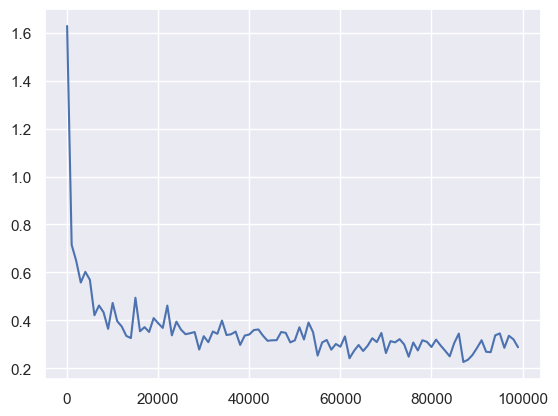

In [20]:
PLT_STEP = 1000
plt.plot(stepi[::PLT_STEP], lossi[::PLT_STEP]);

### Evaluate.

In [21]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, CONTEXT*EMB_DIM) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2146, grad_fn=<NllLossBackward0>)

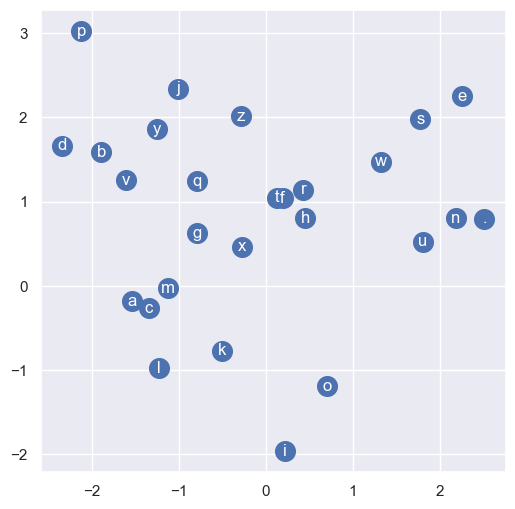

In [22]:
# Visualize dimensions 0 and 1 of the embedding matrix C for all characters
# NOTE: This is meaningless unless we apply PCA.
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

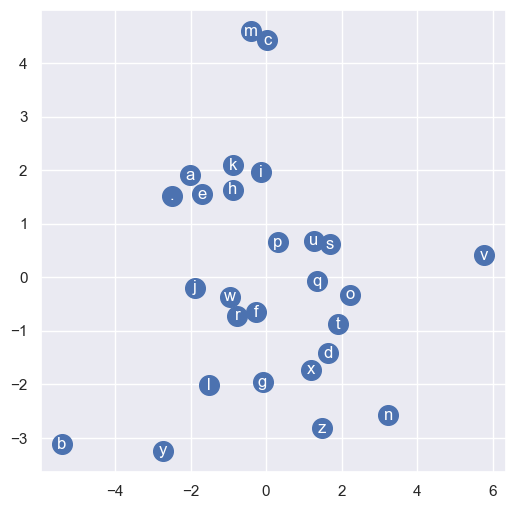

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the embeddings.
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(C.detach().numpy())

# Perform PCA to reduce dimensionality.
n_components = 2
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_embeddings)

# Visualize dimensions 0 and 1 of pca_result.
plt.figure(figsize=(6,6))
plt.scatter(pca_result[:,0], pca_result[:,1], s=200)
for i in range(pca_result.shape[0]):
    plt.text(pca_result[i,0], pca_result[i,1], itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [24]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 40])

In [25]:
# sample from the model
g = torch.Generator().manual_seed(SEED + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # init == ...
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
niha.
alee.
than.
endra.
gradleyda.
lille.
poren.
eden.
est.
aarvelyzion.
kalin.
shubergian.
jest.
jair.
jennex.
ter.
finn.


^^ These look like reasonable names. :)